In [1]:
# Automatically find unified label space from co-occurance of detector results.

import json
import torch
import numpy as np
import sys
from collections import defaultdict
from pycocotools import mask as maskutils
import numba
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# datapath 
ROOT_PATH = 'datasets/'

sys.path.insert(0, ROOT_PATH)
meta_data_path = ROOT_PATH + 'metadata/det_categories.json' # category info from annotation json
ANN_PATH = {
    'objects365': ROOT_PATH + 'objects365/annotations/objects365_val.json',
    'coco': ROOT_PATH + 'coco/annotations/instances_val2017.json',
    'oid': ROOT_PATH + 'oid/annotations/oid_challenge_2019_val_expanded.json'
}

EXP_NAME = 'Partitioned_COI_RS101_2x'
DATA_PATH = {
    'objects365': ROOT_PATH + 'logits/{}/inference_objects365_val/unified_instances_results.json'.format(EXP_NAME),
    'coco': ROOT_PATH + 'logits/{}/inference_coco_2017_val/unified_instances_results.json'.format(EXP_NAME),
    'oid': ROOT_PATH + 'logits/{}/inference_oid_val_expanded/unified_instances_results.json'.format(EXP_NAME),
}
datasets = ['objects365', 'coco', 'oid']

In [3]:
# load meta data
categories = json.load(open(meta_data_path, 'r'))
predid2name, id2sourceid, id2sourceindex, id2sourcename = [], [], [], []
names = []
for d in datasets:
    predid2name.extend([d + '_' + x['name'] for x in sorted(
        categories[d], key=lambda x:x['id'])])
    id2sourceid.extend([x['id'] for x in sorted(
        categories[d], key=lambda x:x['id'])])
    id2sourceindex.extend([i for i, _ in enumerate(sorted(
        categories[d], key=lambda x:x['id']))])
    id2sourcename.extend([d for _ in range(len(categories[d]))])
    names.extend([d + '_' + x['name'] for x in sorted(
        categories[d], key=lambda x:x['id'])])
    print('len(categories[d])', d, len(categories[d]))

len(categories[d]) objects365 365
len(categories[d]) coco 80
len(categories[d]) oid 500


In [4]:
# function to load detection results
def create_index(boxes, is_gt=False, score_thresh=-1, cats=None):
    '''
    inputs:
      boxes: list of dicts in coco format {'image_id', 'category_id', 'bbox', 'scores'}
    returns:
      dict of (dict of (list of dict)): per category predictions
    '''
    if cats is not None:
        ret = {x: defaultdict(list) for x in cats}
    else:
        ret = {}
    for x in boxes:
        if x['category_id'] not in ret:
            ret[x['category_id']] = defaultdict(list)
        if is_gt:
            ret[x['category_id']][x['image_id']].append(
                {'bbox': x['bbox'], 'iscrowd': x['iscrowd']})
        else:
            if x['score'] > score_thresh:
                ret[x['category_id']][x['image_id']].append(
                    {'bbox': x['bbox'], 'score': x['score']})
    for cat in ret:
        for image_id in ret[cat]:
            if not is_gt:
                ret[cat][image_id] = sorted(ret[cat][image_id], key=lambda x: - x['score'])
                scores = [x['score'] for x in ret[cat][image_id]]
                bboxes = [x['bbox'] for x in ret[cat][image_id]]
                ret[cat][image_id] = {'scores': scores, 'bboxes': bboxes}
            else:
                ret[cat][image_id] = sorted(ret[cat][image_id], key=lambda x: x['iscrowd'])
                iscrowd = [x['iscrowd'] for x in ret[cat][image_id]]
                bboxes = [x['bbox'] for x in ret[cat][image_id]]
                ret[cat][image_id] = {'iscrowd': iscrowd, 'bboxes': bboxes}
    return ret

# load detection annotations and predictions
all_anns, all_preds, gtid2name = {}, {}, {}
for d in datasets:
  print('Loading anns...', ANN_PATH[d])
  anns = json.load(open(ANN_PATH[d], 'r'))
  print('Loading preds...', DATA_PATH[d])
  preds = json.load(open(DATA_PATH[d], 'r'))
  all_anns[d] = create_index(anns['annotations'], True, 
                             cats=[x['id'] for x in anns['categories']])
  all_preds[d] = create_index(preds, score_thresh=0.1)
  gtid2name[d] = {x['id']: x['name'] for x in anns['categories']}
  del anns
  del preds

Loading anns... datasets/objects365/annotations/objects365_val.json
Loading preds... datasets/logits/Partitioned_COI_RS101_2x/inference_objects365_val/unified_instances_results.json
Loading anns... datasets/coco/annotations/instances_val2017.json
Loading preds... datasets/logits/Partitioned_COI_RS101_2x/inference_coco_2017_val/unified_instances_results.json
Loading anns... datasets/oid/annotations/oid_challenge_2019_val_expanded.json
Loading preds... datasets/logits/Partitioned_COI_RS101_2x/inference_oid_val_expanded/unified_instances_results.json


In [5]:
@numba.jit(nopython=True, nogil=True)
def find_match(ious, iscrowd, n, m):
    matched = [0 for _ in range(m)] # m
    dtig = [0 for _ in range(n)] # n
    dtm = [0 for _ in range(n)] # n
    for dind in range(n):
        iou = 0.5
        mt = -1
        for gind in range(m):
            if matched[gind] > 0 and iscrowd[gind] == 0:
                continue
            if mt > -1 and iscrowd[mt] == 0 and iscrowd[gind] == 1:
                break
            if ious[dind, gind] < iou:
                continue
            iou = ious[dind, gind]
            mt = gind
        if mt == -1:
            continue
        dtig[dind] = iscrowd[mt]
        dtm[dind] = 1
        matched[mt] = 1
    return matched, dtig, dtm

# COCO mAP
def numba_mAP(preds, gts):
    '''
    inputs: 
      preds: dict of (list of dict): prediction list indexed by image id (one category)
      gts: dict of (list of dict): prediction list indexed by image id (one category)
    '''
    image_ids = gts.keys()
    all_scores, all_dtm, all_dtig, all_gtig = [], [], [], []
    cur_gt, cur_match = 0, 0
    for idx, image_id in enumerate(image_ids):
        # pruning for efficiency
        if cur_gt > 100 and cur_match < 10:
            return 0
        if image_id in preds and ('scores' in preds[image_id]):
            scores = preds[image_id]['scores']
            dt = preds[image_id]['bboxes']
        else:
            scores = []
            dt = []
        if 'iscrowd' in gts[image_id]:
            gt = gts[image_id]['bboxes']
            iscrowd = gts[image_id]['iscrowd']
        else:
            gt = []
            iscrowd = []
        n, m = len(dt), len(gt)
        ious = maskutils.iou(dt, gt, iscrowd) # n x m
        if n > 0 and m > 0:
            matched, dtig, dtm = find_match(ious, iscrowd, n, m)
        else:
            matched = [0 for _ in range(m)] # m
            dtig = [0 for _ in range(n)] # n
            dtm = [0 for _ in range(n)] # n
        cur_gt = cur_gt + len(gt)
        cur_match = cur_match + sum(matched)
        all_scores.extend(scores)
        all_dtm.extend(dtm)
        all_dtig.extend(dtig)
        all_gtig.extend(iscrowd)
    all_scores = np.array(all_scores, dtype=np.float32)
    all_dtm = np.array(all_dtm, dtype=np.int32)
    all_dtig = np.array(all_dtig, dtype=np.int32)
    inds = np.argsort(-all_scores, kind='mergesort')
    all_scores = all_scores[inds]
    all_dtm = all_dtm[inds]
    all_dtig = all_dtig[inds]
    N = len(all_scores)
    tps = (all_dtm == 1) & (all_dtig == 0) # N
    fps = (all_dtm == 0) & (all_dtig == 0) # N
    nvalid = np.count_nonzero(np.array(all_gtig, dtype=np.int32)==0)
    if nvalid == 0:
        return 0
    tp_sum = np.cumsum(tps).astype(dtype=np.float32) # N
    fp_sum = np.cumsum(fps).astype(dtype=np.float32) # N
    rc = tp_sum / nvalid
    pr = (tp_sum / (fp_sum + tp_sum + 1e-8)).tolist()
    for i in range(N-1, 0, -1):
        if pr[i] > pr[i - 1]:
            pr[i - 1] = pr[i]
    recThrs = np.linspace(.0, 1.00, int(np.round((1.00 - .0) / .01)) + 1, endpoint=True)
    inds = np.searchsorted(rc, recThrs, side='left')
    q = np.zeros(len(recThrs))
    try:
        for ri, pi in enumerate(inds):
            q[ri] = pr[pi]
    except:
        pass
    return q.mean()

In [6]:
# Pre-calulate mAP for all class pairs
mAPs_all = {}
mAPs_ori = {}
for d in datasets:
    print('d', d)
    mAPs_all[d] = np.zeros((len(all_preds[d]), len(all_anns[d])), dtype=np.float32)
    mAPs_ori[d] = np.zeros(len(all_anns[d]), dtype=np.float32)
    time_st = time.time()
    for j, gt_cat in enumerate(sorted(all_anns[d].keys())):
        for i in sorted(all_preds[d].keys()):
            pred_name = predid2name[i]
            if pred_name.startswith(d):
                continue
            mAPs_all[d][i, j] = numba_mAP(all_preds[d][i], all_anns[d][gt_cat])
        inds = np.argsort(-mAPs_all[d][:, j])
        i_ori = [i for i in all_preds[d].keys() if predid2name[i] == '{}_{}'.format(d, gtid2name[d][gt_cat])]
        i_ori = i_ori[0]
        ori_map = numba_mAP(all_preds[d][i_ori], all_anns[d][gt_cat])
        mAPs_all[d][i_ori, j] = ori_map
        mAPs_ori[d][j] = ori_map
        print('{} {:.3f}'.format(gtid2name[d][gt_cat], ori_map), end=',')
        for k in range(5):
            if mAPs_all[d][inds[k], j] > 0.01:
                print('{} {:.3f}'.format(predid2name[inds[k]], mAPs_all[d][inds[k], j]), end=', ')
        print()
    print('time =', time.time() - time_st)

d objects365


C:\Users\zhoux\anaconda3\lib\site-packages\numba\ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'iscrowd' of function 'find_match'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-5-41f725592760>", line 2:
@numba.jit(nopython=True, nogil=True)
def find_match(ious, iscrowd, n, m):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
C:\Users\zhoux\anaconda3\lib\site-packages\numba\ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'iscrowd' of function 'find_match'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-5-41f725592760>"

person 0.783,coco_person 0.777, oid_Person 0.767, oid_Man 0.652, oid_Woman 0.342, objects365_person 0.783, 
sneakers 0.666,oid_Footwear 0.563, 
chair 0.565,coco_chair 0.580, oid_Chair 0.534, oid_Furniture 0.244, 
hat 0.704,oid_Hat 0.338, 
lamp 0.602,oid_Lamp 0.262, 
bottle 0.489,coco_bottle 0.454, oid_Bottle 0.259, oid_Drink 0.095, oid_Tableware 0.090, 
cabinet/shelf 0.572,oid_Cabinetry 0.303, oid_Cupboard 0.256, oid_Furniture 0.194, oid_Shelf 0.113, oid_Chest of drawers 0.106, 
cup 0.539,coco_cup 0.527, oid_Tableware 0.106, oid_Coffee cup 0.091, oid_Drink 0.084, 
car 0.651,coco_car 0.648, oid_Car 0.517, oid_Land vehicle 0.400, oid_Vehicle 0.387, coco_truck 0.016, 
glasses 0.630,oid_Glasses 0.291, 
picture/frame 0.788,oid_Picture frame 0.670, 
desk 0.506,oid_Table 0.418, coco_dining table 0.298, oid_Furniture 0.206, oid_Desk 0.153, oid_Coffee table 0.118, 
handbag 0.413,coco_handbag 0.340, oid_Handbag 0.161, oid_Luggage and bags 0.128, coco_backpack 0.047, 
street lights 0.582,oid_Stre

In [7]:
@numba.jit(nopython=True, nogil=True)
def np_nms(boxes, scores, thresh):
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2] + boxes[:, 0]
    y2 = boxes[:, 3] + boxes[:, 1]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep

def merge_boxes(boxes_list):
    all_image_ids = set()
    for boxes_cat in boxes_list:
        all_image_ids = all_image_ids.union(boxes_cat.keys())
    ret = {}
    for image_id in all_image_ids:
        all_boxes, all_scores = [], []
        for x in boxes_list:
            if image_id in x and 'bboxes' in x[image_id]:
                all_boxes.extend(x[image_id]['bboxes'])
                all_scores.extend(x[image_id]['scores'])
        if len(all_boxes) == 0:
            continue
        all_boxes = np.array(all_boxes).reshape(-1, 4)
        all_scores = np.array(all_scores).reshape(-1)
        keep = np_nms(all_boxes, all_scores, 0.5)
        all_boxes = all_boxes[keep]
        all_scores = all_scores[keep]
        all_boxes = all_boxes.tolist()
        all_scores = all_scores.tolist()
        ret[image_id] = {'bboxes': all_boxes, 'scores': all_scores}
        
    return ret

In [8]:
calced_cost = {}
def calc_cost(cats):
    cats = sorted(cats)
    if tuple(cats) in calced_cost:
        return calced_cost[tuple(cats)]
    num_cats = len(cats)
    sources = [id2sourcename[c] for c in cats]
    ret = 0
    for c, s in zip(cats, sources):
        ann_ind = id2sourceindex[c] 
        ann_cat = id2sourceid[c]
        ori_mAP = mAPs_all[s][c, ann_ind] 
        merged = merge_boxes([all_preds[s][cc] for cc in cats])
        merged_mAP = numba_mAP(merged, all_anns[s][ann_cat])
        ret += ori_mAP - merged_mAP

    calced_cost[tuple(cats)] = ret
    nemes = [predid2name[c] for c in cats]
    print(*nemes, ret)
    return ret

In [9]:
datasets = ['objects365', 'coco', 'oid']
num_cats = [365, 80, 500]
cnt = 0
dataset_range = {}
for d, c in zip(datasets, num_cats):
  dataset_range[d] = range(cnt, cnt + c)
  cnt = cnt + c
print('dataset_range', dataset_range)
id2source = np.concatenate(
    [np.ones(len(dataset_range[d]), dtype=np.int32) * i \
        for i, d in enumerate(datasets)]
).tolist()
N = sum(num_cats)

dataset_range {'objects365': range(0, 365), 'coco': range(365, 445), 'oid': range(445, 945)}


In [10]:
max_new_nodes = {
    2: 1000, 3: 1000
}
n2 = max_new_nodes[2]
tau = 0.2
oo = 1000

# Initialize two-node merge
dataset_dists = {}
cnt = 0
for d1, a in enumerate(datasets):
    for d2, b in enumerate(datasets[d1+1:]):
        dist = np.ones(
            (len(dataset_range[a]), len(dataset_range[b])), dtype=np.float32) * oo
        for i in range(len(dataset_range[a])):
            for j in range(len(dataset_range[b])):
                if mAPs_all[a][j+dataset_range[b][0], i] > max(mAPs_ori[a][i] - tau, 0) and \
                    mAPs_all[b][i+dataset_range[a][0], j] > max(mAPs_ori[b][j] - tau, 0):
                    dist[i][j] = calc_cost([i + dataset_range[a][0], j + dataset_range[b][0]])
                    cnt += 1
        dataset_dists[(d1, d2 + d1 + 1)] = dist

score_thresh = 0.05
Q = []
nodes = {}
valid_two_nodes = {}
for (i, j) in dataset_dists:
    a, b = datasets[i], datasets[j]
    ra, rb = dataset_range[a], dataset_range[b]
    dist = dataset_dists[(i, j)] # Ni x Nj
    mask = np.any(
        [dist <= np.partition(
            dist, min(n2, dist.shape[k])-1, axis=k
          ).take([min(n2, dist.shape[k])-1], axis=k) for k in range(2)], axis=0) # Ni x Nj
    mask = mask & (dist <= score_thresh)
    nodes[(i, j)] = list(zip(dist[mask],
                          *[np.array(x)[w] for x, w in zip((ra, rb), np.where(mask))]))
    valid_two_nodes[(i, j)] = set([tuple(sorted((x[1], x[2]))) for x in nodes[(i, j)]])
    Q.append((i, j))
print('#valid two node merge:', sum(len(v) for k, v in nodes.items()))

objects365_person coco_person -0.004173702532702106
objects365_chair coco_chair -0.020545590041887607
objects365_bottle coco_bottle -0.01201157788238899
objects365_cup coco_cup -0.01410870770416639
objects365_car coco_car 0.007841109934419666
objects365_handbag coco_handbag -0.0007549105304302528
objects365_potted plant coco_potted plant 0.015291694662358468
objects365_tv coco_tv -0.003846611126814725
objects365_vase coco_vase 0.0019043138121613845
objects365_bench coco_bench -0.003963088635170864
objects365_wine glass coco_wine glass -0.0019732300597842256
objects365_bowl coco_bowl -0.001933284915319744
objects365_dining table coco_dining table -0.06591526765634514
objects365_umbrella coco_umbrella 0.008774362283177961
objects365_boat coco_boat 0.03709572288069396
objects365_backpack coco_backpack -0.017546705680318353
objects365_couch coco_couch -0.011309905217425698
objects365_tie coco_tie -0.003182089269751387
objects365_bed coco_bed 0.008930062598521138
objects365_traffic light co

C:\Users\zhoux\anaconda3\lib\site-packages\ipykernel_launcher.py:40: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


objects365_person coco_person oid_Man 0.012958781553967125
objects365_person coco_person oid_Person -0.042491667931622734
objects365_chair coco_chair oid_Chair -0.08492186429476978
objects365_car coco_car oid_Car 0.008081395732294161
objects365_potted plant coco_potted plant oid_Houseplant -0.02989301085472107
objects365_bench coco_bench oid_Bench -0.6764567860282293
objects365_wine glass coco_wine glass oid_Wine glass -0.06528172870673754
objects365_umbrella coco_umbrella oid_Umbrella -0.06259702868980943
objects365_boat coco_boat oid_Watercraft 0.025823159678147634
objects365_boat coco_boat oid_Boat 0.0005251074781511544
objects365_backpack coco_backpack oid_Backpack -0.061305396627671704
objects365_couch coco_couch oid_Sofa bed -0.009283519617401703
objects365_couch coco_couch oid_Couch -0.03539077598269613
objects365_couch coco_couch oid_Loveseat -0.06470044650653806
objects365_couch coco_couch oid_studio couch -0.04391905134267149
objects365_tie coco_tie oid_Tie -0.075105455547276

(array([374.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 210.]),
 array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ]),
 <a list of 10 Patch objects>)

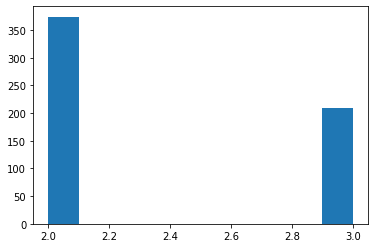

In [11]:
# three-dataset merge
def remove_duplicate(list1, list2):
    tmp = list1 + list2
    tmp = sorted(tmp, key=lambda x:x[1:])
    ret = [tmp[0]]
    for i in range(1, len(tmp)):
        if tmp[i][1:] != tmp[i-1][1:]:
            ret.append(tmp[i])
    return tmp


def get_new_candidates(candidates, ds, new_dataset_id, score_thresh):
    '''
    condidates: list of (score, id1, id2, ...)
    ds: list of existing dataset ids
    '''
    ret = []
    if len(candidates) == 0:
        print('No candidates for', [datasets[d] for d in ds])
        return ret
    n = len(candidates[0]) - 1
    tonew = dataset_range[datasets[new_dataset_id]]
    for item in candidates:
        cost = item[0]
        ids = list(item[1:])
        sources = [id2source[x] for x in ids]
        new_candidates = []
        for new_id in tonew:
            valid = True
            for id, source in zip(ids, sources):
                dataset_pair = tuple(sorted((source, new_dataset_id)))
                id_pair = tuple(sorted((id, new_id)))
                if id_pair not in valid_two_nodes[dataset_pair]:
                    valid = False
                    break
            if valid:
                new_cost = calc_cost(sorted(ids + [new_id]))
                new_candidates.append(
                    (new_cost, *tuple(sorted(ids + [new_id]))))
        new_candidates = sorted(new_candidates)[:max_new_nodes[len(ids) + 1]]
        new_candidates = [x for x in new_candidates if x[0] <= score_thresh]
        ret.extend(new_candidates)
        
    return ret

left = 0
while left < len(Q):
    ds = Q[left]
    candidates = nodes[ds]
    left = left + 1
    for k, c in enumerate(datasets):
        if k not in ds:
            new_datasets = tuple(sorted(list(ds) + [k]))
            new_candidates = get_new_candidates(candidates, ds, k, score_thresh=tau)
            if new_datasets in nodes and len(nodes[new_datasets]) > 0:
                nodes[new_datasets] = remove_duplicate(
                    nodes[new_datasets], new_candidates)
            else:
                nodes[new_datasets] = new_candidates
                Q.append(new_datasets)

top_clusters = [] # formart: (score, id1, id2, ...)
for ds, candidates in nodes.items():
    top_clusters.extend(candidates)
print(len(c)-1 for c in top_clusters)
hist([len(c)-1 for c in top_clusters])

In [12]:
# !sudo apt install coinor-cbc coinor-libcbc-dev
# !pip install cylp

In [13]:
# Running optimization
from cylp.cy import CyClpSimplex
from cylp.py.modeling.CyLPModel import CyLPArray, CyLPModel

cost = CyLPArray([c[0] * (len(c) - 1.) for c in top_clusters])
size = CyLPArray([len(c)-2. for c in top_clusters])

m = CyLPModel()
x = m.addVariable('x', len(top_clusters), isInt=True)

weight = 0.5 # lambda in the paper

# add constraints
m += 0 <= x
m += x <= 1

# No overlapping clusters
cluster_set = [[] for _ in range(N)]
for i, c in enumerate(top_clusters):
    for a in c[1:]:
        cluster_set[a].append(i)

for s in cluster_set:
    if len(s):
        w = np.zeros(len(top_clusters))
        w[s] = 1
        m += CyLPArray(w) * x <= 1
        
# Objective
m.objective = sum((cost - weight * size) * x)

print('C', m.nVars, m.nCons)

s = CyClpSimplex(m)
r = s.primal()
sol_x = s.primalVariableSolution['x']
print(r, np.sum(sol_x), N - sum(size * sol_x), sum(cost * sol_x), weight * (1.0 * N - 1.0 * sum(size * sol_x)))
print('num_classes', int(N - sum(size * sol_x) + 1e-7))

C 584 480
optimal 189.00000000018002 700.999999999771 -20.8646632466205 350.4999999998855
num_classes 701


In [14]:
# Visualize merged classes
for i, s in enumerate(sol_x):
    if s > 0.1:
        print('%4.1f %7.4f'%(s, top_clusters[i][0]), *['%-50s'%names[j] for j in top_clusters[i][1:]])

 1.0 -0.0120 objects365_bottle                                  coco_bottle                                       
 1.0 -0.0141 objects365_cup                                     coco_cup                                          
 1.0 -0.0659 objects365_dining table                            coco_dining table                                 
 1.0 -0.0257 objects365_cake                                    coco_cake                                         
 1.0 -0.0743 objects365_wild bird                               coco_bird                                         
 1.0 -0.0039 objects365_knife                                   coco_knife                                        
 1.0  0.0011 objects365_remote                                  coco_remote                                       
 1.0 -0.0112 objects365_microwave                               coco_microwave                                    
 1.0 -0.0185 objects365_frisbee                                 coco_frisbee    

In [15]:
# Print google sheet friendly version
change_oid_names = ['Mouse', 'Bench']
for change_oid_name in change_oid_names:
    cnt = 0
    for x in categories['oid']:
        if x['name'] == change_oid_name:
            cnt = cnt + 1
            x['name'] = '{}{}'.format(change_oid_name, cnt)
            # print('Renaming oid', change_oid_name, \
            #       'to', x['name'])
oidname2freebase = {x['name']: x['freebase_id'] for x in categories['oid']}
oidname2freebase[''] = ''
names = []
for d in datasets:
    names.extend([x['name'] for x in sorted(categories[d], key=lambda x:x['id'])])
merged = [False for _ in range(len(names))]
print_order = ['oid', 'objects365', 'coco',]
heads = ['oid_freebase', 'oid_name', 'objects365_name', 'coco_name', ]
head_str = 'key'
for head in heads:
    head_str = head_str + ', {}'.format(head)
print(head_str)
cnt = 0
for i, s in enumerate(sol_x):
    if s > 0.1:
        inds = top_clusters[i][1:]
        dataset_name = {d: '' for d in datasets}
        for ind in inds:
          merged[ind] = True
          d = datasets[id2source[ind]]
          name = names[ind]
          dataset_name[d] = name
        if name == 'background':
          continue
        unified_name = dataset_name[print_order[0]]
        for d in print_order[1:]:
            unified_name = unified_name + '_{}'.format(dataset_name[d])
        print(unified_name, end='')
        cnt = cnt + 1
        for d in print_order:
            if d == 'oid':
                print(', {}, {}'.format(oidname2freebase[dataset_name[d]], dataset_name[d]), end='')
            else:
                print(', {}'.format(dataset_name[d]), end='')
        print()
for ind in range(len(names)):
  if not merged[ind]:
    dataset_name = {d: '' for d in datasets}
    d = datasets[id2source[ind]]
    name = names[ind]
    if name == 'background':
      continue
    dataset_name[d] = name
    unified_name = dataset_name[print_order[0]]
    for d in print_order[1:]:
        unified_name = unified_name + '_{}'.format(dataset_name[d])
    print(unified_name, end='')
    cnt = cnt + 1
    for d in print_order:
        if d == 'oid':
            print(', {}, {}'.format(oidname2freebase[dataset_name[d]], dataset_name[d]), end='')
        else:
            print(', {}'.format(dataset_name[d]), end='')
    print()
print()
print('num_cats', cnt)

key, oid_freebase, oid_name, objects365_name, coco_name
_bottle_bottle, , , bottle, bottle
_cup_cup, , , cup, cup
_dining table_dining table, , , dining table, dining table
_cake_cake, , , cake, cake
_wild bird_bird, , , wild bird, bird
_knife_knife, , , knife, knife
_remote_remote, , , remote, remote
_microwave_microwave, , , microwave, microwave
_frisbee_frisbee, , , frisbee, frisbee
_toothbrush_toothbrush, , , toothbrush, toothbrush
Footwear_sneakers_, /m/09j5n, Footwear, sneakers, 
Picture frame_picture/frame_, /m/06z37_, Picture frame, picture/frame, 
Table_desk_, /m/04bcr3, Table, desk, 
Street light_street lights_, /m/033rq4, Street light, street lights, 
Book_book_, /m/0bt_c3, Book, book, 
Helmet_helmet_, /m/0zvk5, Helmet, helmet, 
Pillow_pillow_, /m/034c16, Pillow, pillow, 
Box_storage box_, /m/025dyy, Box, storage box, 
Bowl_bowl_, /m/04kkgm, Bowl, bowl, 
Watercraft_boat_, /m/01rzcn, Watercraft, boat, 
Flag_flag_, /m/03120, Flag, flag, 
Stool_stool_, /m/0fqt361, Stool, stool,